# How sensitive is the KL divergence measure to perturbations in the song and perturbations in the model ?

To answer this question:
1. Load two models from different days, P and Q
2. Load two days' data from P and Q
3. Perturb the parameters of Q and compute \avg_P_data log Q, the loglikelihood of P data under perturbed Q and vice versa
4. Perturb the samples of P and compute \avg_P_data log Q, the loglikelihood of perturbed P data under perturbed Q

In [1]:
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
import torch

In [125]:
import os
from os.path import join
import joblib
from data.dataset import bird_dataset_single_hdf
from utils.utils import load_netE, load_netG, overlap_decode, overlap_encode, rescale_spectrogram, to_im
from hmm.kl_divergence import load_sequence_data, load_hmm_model

In [7]:
model1 = load_hmm_model('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/day_18/', '60')

In [8]:
model2 = load_hmm_model('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/day_32/', '60')

In [10]:
day1data = load_sequence_data('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/day_18/hmm_hiddensize_60/')
day2data = load_sequence_data('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/day_32/hmm_hiddensize_60/')

In [12]:
z1 = day1data[0]
z2 = day2data[0]
len(z1)

987

# first measure original 

In [17]:
def get_pointwise_KL(modelP, modelQ, samplesP, samplesQ):
    
    n_p = len(samplesP)
    n_q = len(samplesQ)
    
    PlogP = np.zeros(n_p)
    PlogQ = np.zeros(n_p)
    QlogP = np.zeros(n_q)
    QlogQ = np.zeros(n_q)
    
    KL_P_Q = np.zeros(n_p)
    KL_Q_P = np.zeros(n_q)
    
    for n in range(n_p):

        l = samplesP[n].shape[0]
        PlogP[n] = modelP.score(samplesP[n]) / l
        PlogQ[n] = modelQ.score(samplesP[n]) / l

        KL_P_Q[n] = PlogP[n] - PlogQ[n]
    
    for n in range(n_q):
        
        l = samplesQ[n].shape[0]
        QlogP[n] = modelP.score(samplesQ[n]) / l
        QlogQ[n] = modelQ.score(samplesQ[n]) / l

        KL_Q_P[n] = QlogQ[n] - QlogP[n]
    
    return KL_P_Q, KL_Q_P, PlogP, QlogQ, PlogQ, QlogP

In [18]:
KL_P_Q_orig, KL_Q_P_orig, PlogP_orig, QlogQ_orig, PlogQ_orig, QlogP_orig = get_pointwise_KL(model1, model2, z1, z2)

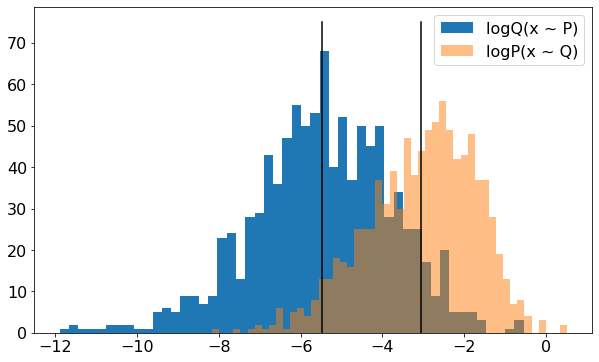

In [90]:
plt.figure(figsize=(10,6))
plt.hist(PlogQ_orig, bins=50)
plt.hist(QlogP_orig, bins=50, alpha=0.5)
plt.legend(['logQ(x ~ P)','logP(x ~ Q)'])
plt.plot([PlogQ_orig.mean(), PlogQ_orig.mean()], [0, 75],'-k')
plt.plot([QlogP_orig.mean(), QlogP_orig.mean()], [0, 75],'-k')
plt.show()
#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure3/p20r16_nz12_hmm60_day18_day32_PlogQ_QlogP.jpg',
#           dpi=100, format='jpg')
#plt.close()

In [31]:
print(np.mean(KL_P_Q_orig), np.var(KL_P_Q_orig))

3.6497222228204755 1.7178785634355034


In [32]:
print(np.mean(KL_Q_P_orig), np.var(KL_Q_P_orig))

2.196217251157104 0.9710499238174446


# flip vectors in some of the sequences

In [70]:
z1_flipped = []

num_flips = 2
gap = 1

for n in range(len(z1)):
    
    z1_flipped.append(z1[n] * 1.)
    
    # choose num_flips flipping points at random
    ids = np.random.choice(z1[n].shape[0]-1, size=num_flips, replace=False)
    
    # flip at those points
    for i in ids:
        z1_flipped[-1][i,:], z1_flipped[-1][i + gap,:] = z1[n][i + gap,:], z1[n][i,:]
        

In [65]:
z1_flippedgap2 = []

num_flips = 1
gap = 5

for n in range(len(z1)):
    
    z1_flippedgap2.append(z1[n] * 1.)
    
    # choose num_flips flipping points at random
    ids = np.random.choice(z1[n].shape[0]-gap, size=num_flips, replace=False)
    
    # flip at those points
    for i in ids:
        z1_flippedgap2[-1][i,:], z1_flippedgap2[-1][i + gap,:] = z1[n][i + gap,:], z1[n][i,:]
        

# measure DKL again

In [33]:
KL_P_Q_1flip_gap1, KL_Q_P_1flip_gap1, PlogP_1flip_gap1, QlogQ_1flip_gap1, PlogQ_1flip_gap1, \
QlogP_1flip_gap1 = get_pointwise_KL(model1, model2, z1_flipped, z2)

In [71]:
KL_P_Q_2flip_gap1, KL_Q_P_2flip_gap1, PlogP_2flip_gap1, QlogQ_2flip_gap1, PlogQ_2flip_gap1, \
QlogP_2flip_gap1 = get_pointwise_KL(model1, model2, z1_flipped, z2)

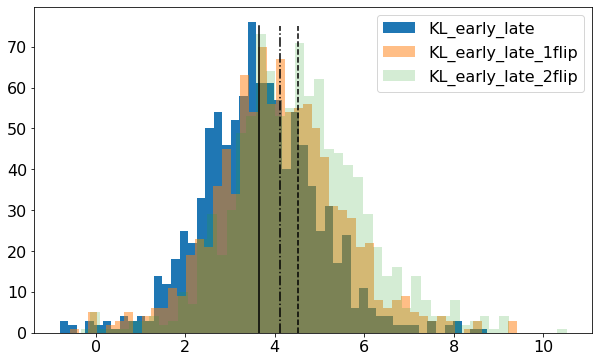

In [92]:
plt.figure(figsize=(10,6))
plt.hist(KL_P_Q_orig, bins=50)
plt.hist(KL_P_Q_1flip_gap1, bins=50, alpha=0.5)
plt.hist(KL_P_Q_2flip_gap1, bins=50, alpha=0.2)

plt.legend(['KL_early_late','KL_early_late_1flip','KL_early_late_2flip'])

plt.plot([KL_P_Q_orig.mean(), KL_P_Q_orig.mean()], [0, 75],'-k')
plt.plot([KL_P_Q_1flip_gap1.mean(), KL_P_Q_1flip_gap1.mean()], [0, 75],'-.k')
plt.plot([KL_P_Q_2flip_gap1.mean(), KL_P_Q_2flip_gap1.mean()], [0, 75],'--k')
#plt.show()
#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure3/p20r16_nz12_hmm60_day18_day32_KLD_1flip_2flip.jpg',
#           dpi=100, format='jpg')
#plt.close()

In [83]:
print(np.mean(KL_P_Q_1flip_gap1), np.var(KL_P_Q_1flip_gap1))
print(np.mean(KL_P_Q_2flip_gap1), np.var(KL_P_Q_2flip_gap1))
print(np.mean(KL_P_Q_orig), np.var(KL_P_Q_orig))

4.12705360240428 1.9369453819600446
4.511342286134047 2.1480277681374744
3.6497222228204755 1.7178785634355034


# gap of five

In [66]:
KL_P_Q_1flip_gap5, KL_Q_P_1flip_gap5, PlogP_1flip_gap5, QlogQ_1flip_gap5, PlogQ_1flip_gap5, \
QlogP_1flip_gap5 = get_pointwise_KL(model1, model2, z1_flippedgap2, z2)

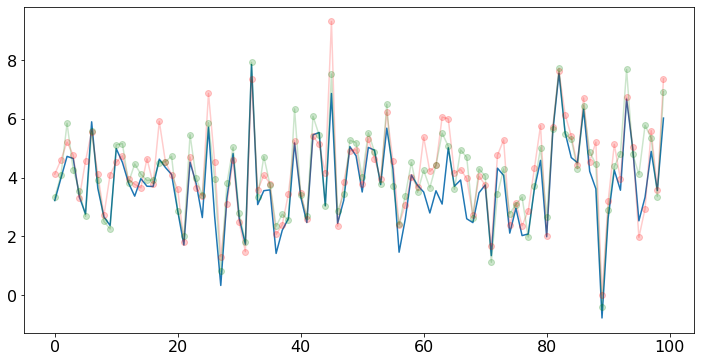

In [96]:
plt.figure(figsize=(12,6))
plt.plot(KL_P_Q_orig[200:300])
plt.plot(KL_P_Q_1flip_gap1[200:300], '-or', alpha=0.2)
plt.plot(KL_P_Q_1flip_gap5[200:300], '-og', alpha=0.2)

In [69]:
print(np.mean(KL_P_Q_1flip_gap5), np.var(KL_P_Q_1flip_gap5))
print(np.mean(KL_P_Q_1flip_gap1), np.var(KL_P_Q_1flip_gap1))
print(np.mean(KL_P_Q_orig), np.var(KL_P_Q_orig))

4.110680008632638 1.8954238423591392
4.12705360240428 1.9369453819600446
3.6497222228204755 1.7178785634355034


In [ ]:
plt.figure(figsize=(10,6))
plt.hist(KL_P_Q_orig, bins=50)
plt.hist(KL_P_Q_1flip_gap1, bins=50, alpha=0.5)

plt.legend(['KL_early_late','KL_late_early'])
plt.plot([KL_P_Q_orig.mean(), KL_P_Q_orig.mean()], [0, 75],'-k')
#plt.text(KL_P_Q_orig.mean(), 75, f'{KL_P_Q_orig.mean()}')
plt.plot([KL_P_Q_1flip_gap1.mean(), KL_P_Q_1flip_gap1.mean()], [0, 75],'-.k')
plt.show()

# add noise 

In [101]:
z1_noise = []

noise_sigma = 0.1

for n in range(len(z1)):
    
    z1_noise.append(z1[n] +  noise_sigma*np.random.randn(*z1[n].shape))
    

In [102]:
KL_P_Q_noise1, KL_Q_P_noise1, PlogP_noise1, QlogQ_noise1, PlogQ_noise1, \
QlogP_noise1 = get_pointwise_KL(model1, model2, z1_noise, z2)

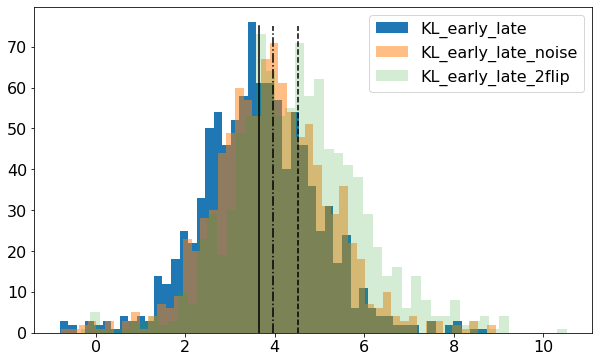

In [180]:
plt.figure(figsize=(10,6))
plt.hist(KL_P_Q_orig, bins=50)
plt.hist(KL_P_Q_noise1, bins=50, alpha=0.5)
plt.hist(KL_P_Q_2flip_gap1, bins=50, alpha=0.2)

plt.legend(['KL_early_late','KL_early_late_noise','KL_early_late_2flip'])

plt.plot([KL_P_Q_orig.mean(), KL_P_Q_orig.mean()], [0, 75],'-k')
plt.plot([KL_P_Q_noise1.mean(), KL_P_Q_noise1.mean()], [0, 75],'-.k')
plt.plot([KL_P_Q_2flip_gap1.mean(), KL_P_Q_2flip_gap1.mean()], [0, 75],'--k')

#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure3/p20r16_nz12_hmm60_day18_day32_KLD_1flip_noisesigma01.jpg',
#           dpi=100, format='jpg')
#plt.close()

# generate output for pitch shift

In [158]:
from data.dataset import transform
from data.create_hdf_dataset import to_image

In [106]:
# load generator
netG = load_netG('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/netG_epoch_40_day_all.pth',
                 nz=12,ngf=128,cuda=True,resnet=True)

In [171]:
netE = load_netE('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/netE_epoch_40_day_all.pth',
                 nz=12,ngf=128,cuda=True,resnet=True)

In [110]:
z1[11].shape

(104, 12)

In [ ]:
z1_stretched = []
stretch_rate = 0.5
for n in range(len(z1)):
    #decode
    _, x_audio = overlap_decode(z1[n], netG, get_audio=True, cuda=True)
    # stretch/compress
    x_stretched = create_time_stretched_spectra(x_audio, stretch_rate, nfft=256)
    # encode
    z1_stretched.append(overlap_encode(x_stretched, netE, cuda=True))
    print('..... done with %.3f percent.....'%(n*100 / len(z1)))

In [ ]:
z1_compress = []
stretch_rate = 2.
for n in range(len(z1)):
    #decode
    _, x_audio = overlap_decode(z1[n], netG, get_audio=True, cuda=True)
    # stretch/compress
    x_stretched = create_time_stretched_spectra(x_audio, stretch_rate, nfft=256)
    # encode
    z1_compress.append(overlap_encode(x_stretched, netE, cuda=True))
    print('..... done with %.3f percent.....'%(n*100 / len(z1)))

..... done with 0.000 percent.....
..... done with 0.101 percent.....
..... done with 0.203 percent.....
..... done with 0.304 percent.....
..... done with 0.405 percent.....
..... done with 0.507 percent.....
..... done with 0.608 percent.....
..... done with 0.709 percent.....
..... done with 0.811 percent.....
..... done with 0.912 percent.....
..... done with 1.013 percent.....
..... done with 1.114 percent.....
..... done with 1.216 percent.....
..... done with 1.317 percent.....
..... done with 1.418 percent.....
..... done with 1.520 percent.....
..... done with 1.621 percent.....
..... done with 1.722 percent.....
..... done with 1.824 percent.....
..... done with 1.925 percent.....
..... done with 2.026 percent.....
..... done with 2.128 percent.....
..... done with 2.229 percent.....
..... done with 2.330 percent.....
..... done with 2.432 percent.....
..... done with 2.533 percent.....
..... done with 2.634 percent.....
..... done with 2.736 percent.....
..... done with 2.83

In [186]:
KL_P_Q_stretched, KL_Q_P_stretched, PlogP_stretched, QlogQ_stretched, PlogQ_stretched, \
QlogP_stretched = get_pointwise_KL(model1, model2, z1_stretched, z2)

In [192]:
plt.figure(figsize=(14,7))
plt.hist(KL_P_Q_orig, bins=50)
#plt.hist(KL_P_Q_noise1, bins=50, alpha=0.5)
#plt.hist(KL_P_Q_2flip_gap1, bins=50, alpha=0.2)
plt.hist(KL_P_Q_stretched, bins=50, alpha=0.2, color='r')

#plt.legend(['KL_early_late','KL_early_late_noise','KL_early_late_2flip'])

plt.plot([KL_P_Q_orig.mean(), KL_P_Q_orig.mean()], [0, 75],'-k')
#plt.plot([KL_P_Q_noise1.mean(), KL_P_Q_noise1.mean()], [0, 75],'-.k')
#plt.plot([KL_P_Q_2flip_gap1.mean(), KL_P_Q_2flip_gap1.mean()], [0, 75],'--k')
plt.plot([KL_P_Q_stretched.mean(), KL_P_Q_stretched.mean()], [0, 75],'--k')

plt.legend(['KL_P_Q_early_late','KL_P_Q_early_late_0.5x_slower'])
#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure3/p20r16_nz12_hmm60_day18_day32_KLD_orig_stretched_2slower.jpg',
#           dpi=100, format='jpg')

#plt.close()

In [139]:
x_.shape

(129, 1664)

In [124]:
x_audio.shape

(106432,)

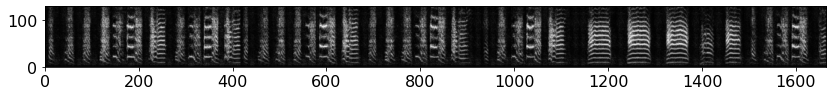

In [129]:
plt.figure(figsize=(14,8))
plt.imshow(rescale_spectrogram(x_), origin='lower', cmap='gray')

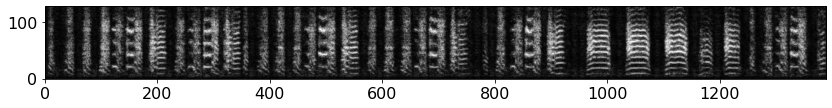

In [167]:
plt.figure(figsize=(14,8))
plt.imshow(rescale_spectrogram(x_str_spec), origin='lower', cmap='gray')

In [133]:
import librosa as lc

In [148]:
D = lc.stft(x_audio, n_fft=256, hop_length=64)
D.shape

(129, 1664)

In [163]:
D_stretched = lc.phase_vocoder(D, 1.2, hop_length=64)

In [164]:
x_stretched = lc.istft(D_stretched)

In [165]:
x_stretched.shape

(88704,)

In [166]:
x_str_spec = transform(to_image(x_stretched, nfft=256))
x_str_spec.shape

(129, 1389)

In [130]:
import pyrubberband

In [ ]:
y_shift = pyrubberband.pitch_shift(x_audio, 16000, 2)

In [170]:
def create_time_stretched_spectra(x, stretch_rate = 1.2, nfft=256):
    
    D = lc.stft(x, n_fft=nfft, hop_length=nfft//4)
    D = lc.phase_vocoder(D, stretch_rate, hop_length=nfft/4)
    x = lc.istft(D)
    return transform(to_image(x, nfft))